In [1]:
# import numpy as np
# import pymc as pm
# from pytensor.tensor import TensorVariable

# def logp(value: TensorVariable, mu: TensorVariable) -> TensorVariable:
#     return -(value - mu)**2

# with pm.Model():
#     mu = pm.Normal('mu',0,1)
#     pm.CustomDist(
#         'custom_dist',
#         mu,
#         logp=logp,
#         observed=np.random.randn(100),
#     )
#     idata = pm.sample(100)

In [2]:
import pymc as pm
import numpy as np

with pm.Model() as model:
    mu = pm.Normal('mu',0,1)
    pm.Normal('obs', mu, 1, observed=np.random.randn(100))

In [3]:
import statsmodels as sm

In [4]:
# generate arma(2,2) data 
import numpy as np
import statsmodels.api as sm

arparams = np.array([.75, -.25])
maparams = np.array([.65, .35])
ar = np.r_[1, -arparams] # add zero-lag and negate
ma = np.r_[1, maparams] # add zero-lag

y = sm.tsa.arma_generate_sample(ar, ma, 250)

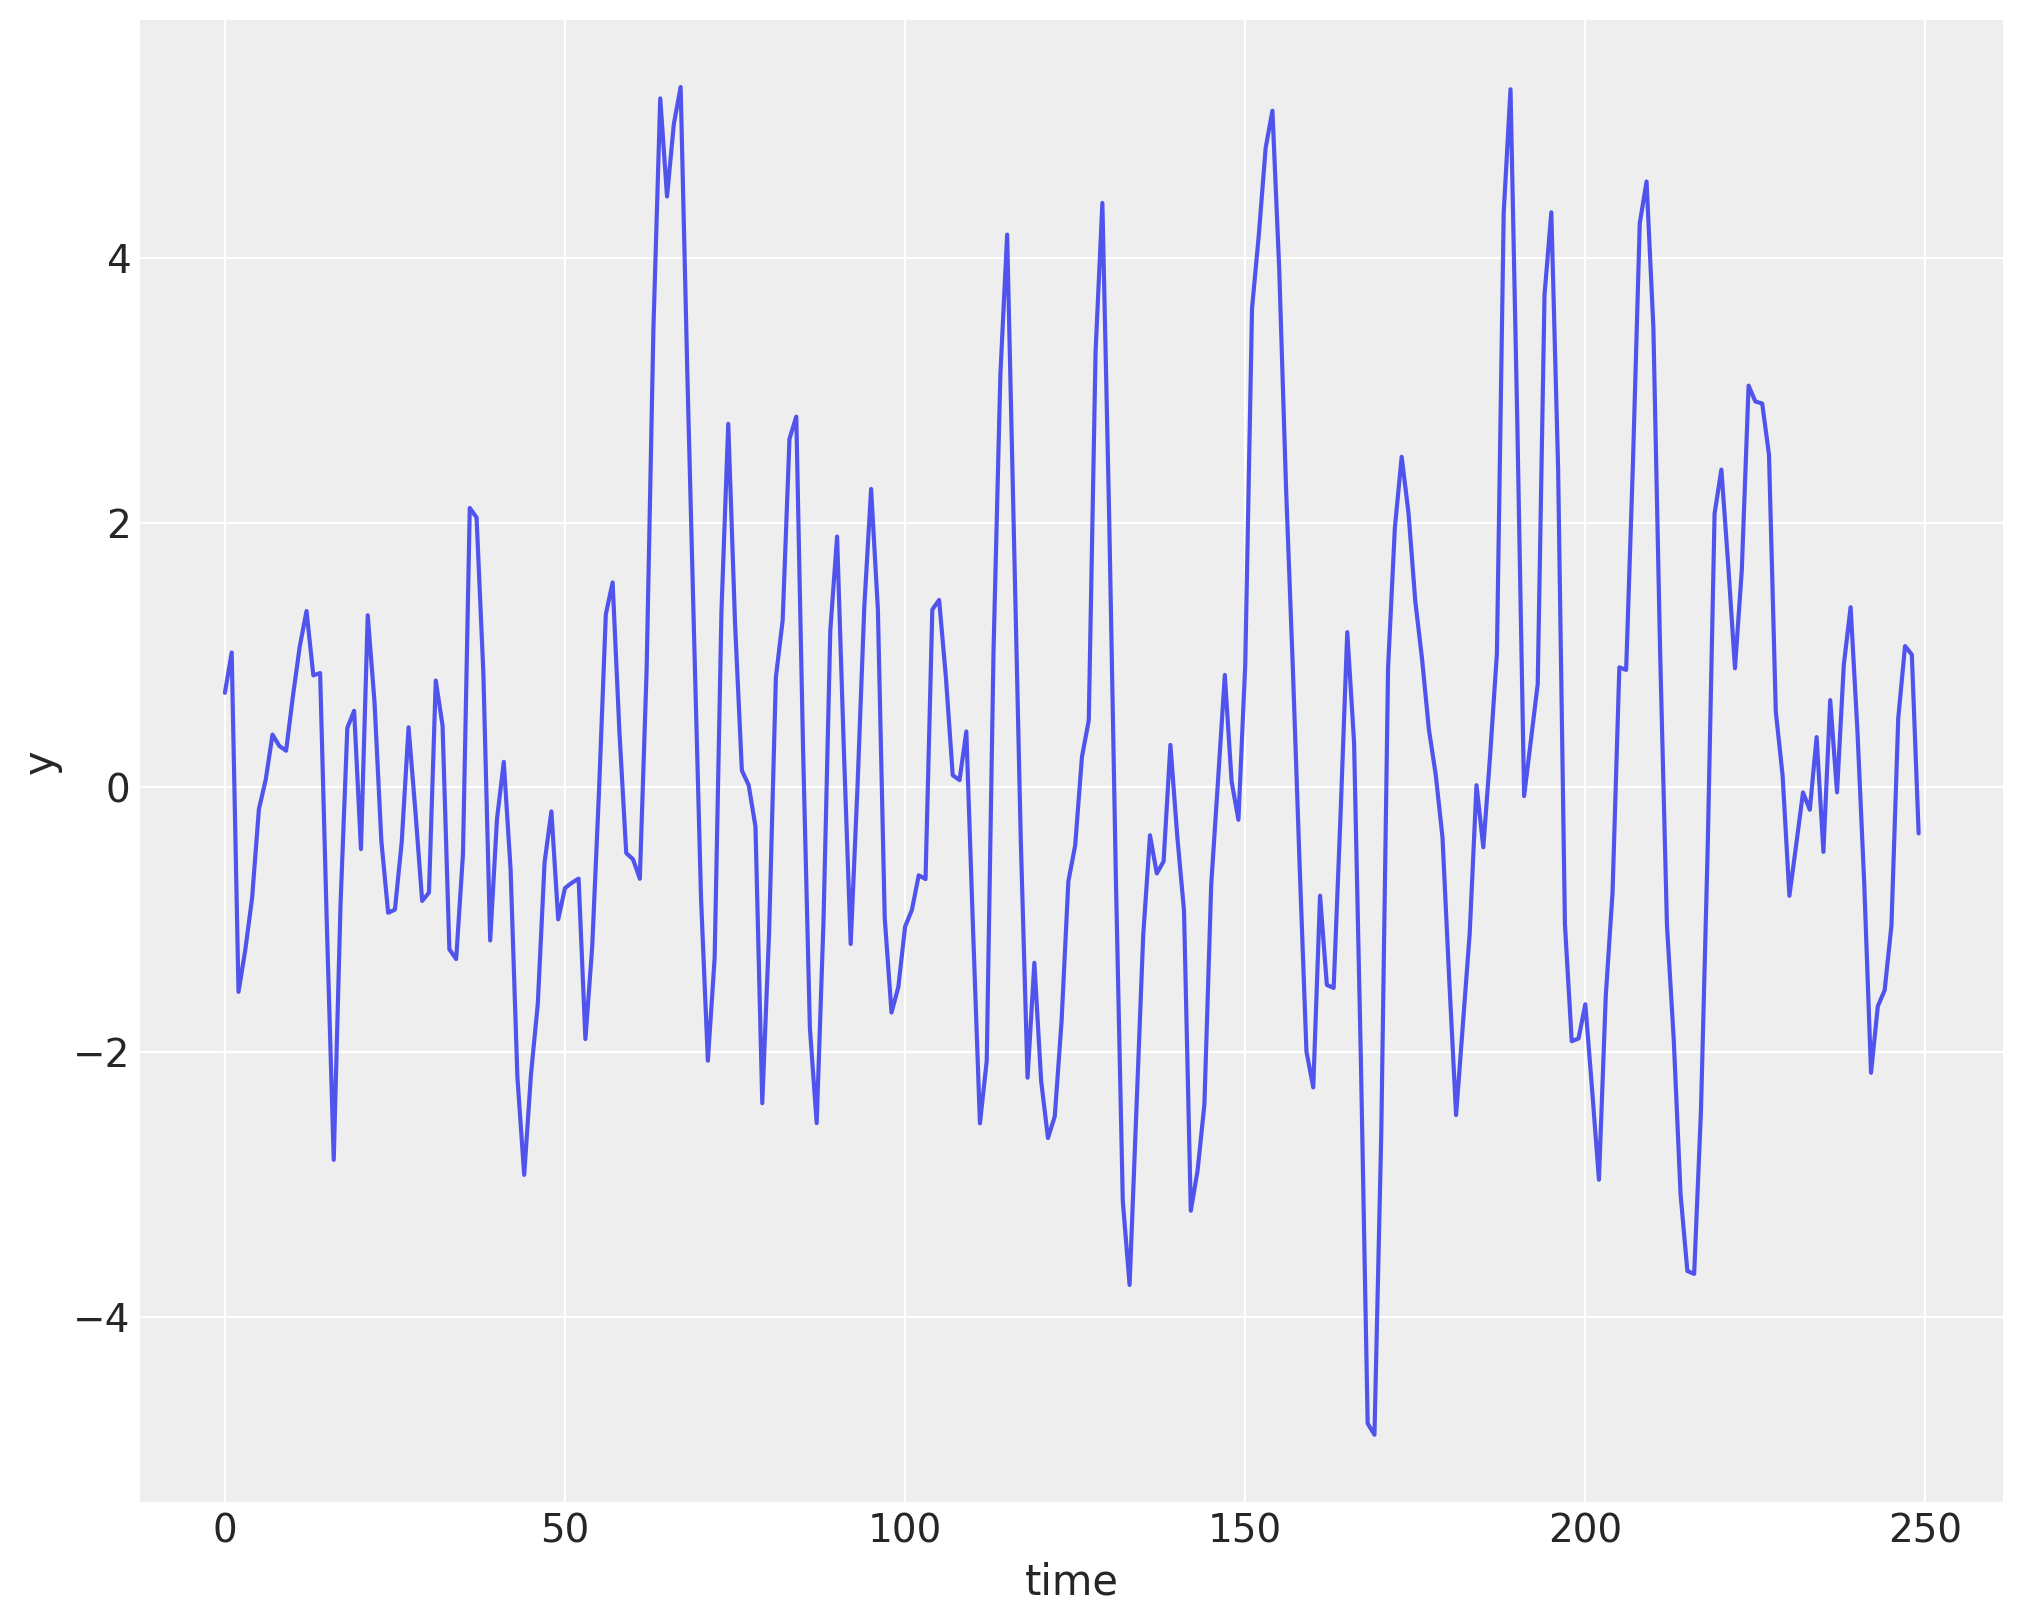

In [5]:
%config InlineBackend.figure_format = 'retina'
import arviz as az
az.style.use('arviz-darkgrid')

# plot time series 
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(y, alpha=.8)
ax.set(xlabel='time', ylabel='y')
plt.show()

/Users/wang/Library/CloudStorage/GoogleDrive-thetheoryofeverythingcn@gmail.com/My Drive/23 Spring/TimeSeries/Project/Bayesian-inference/.venv/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


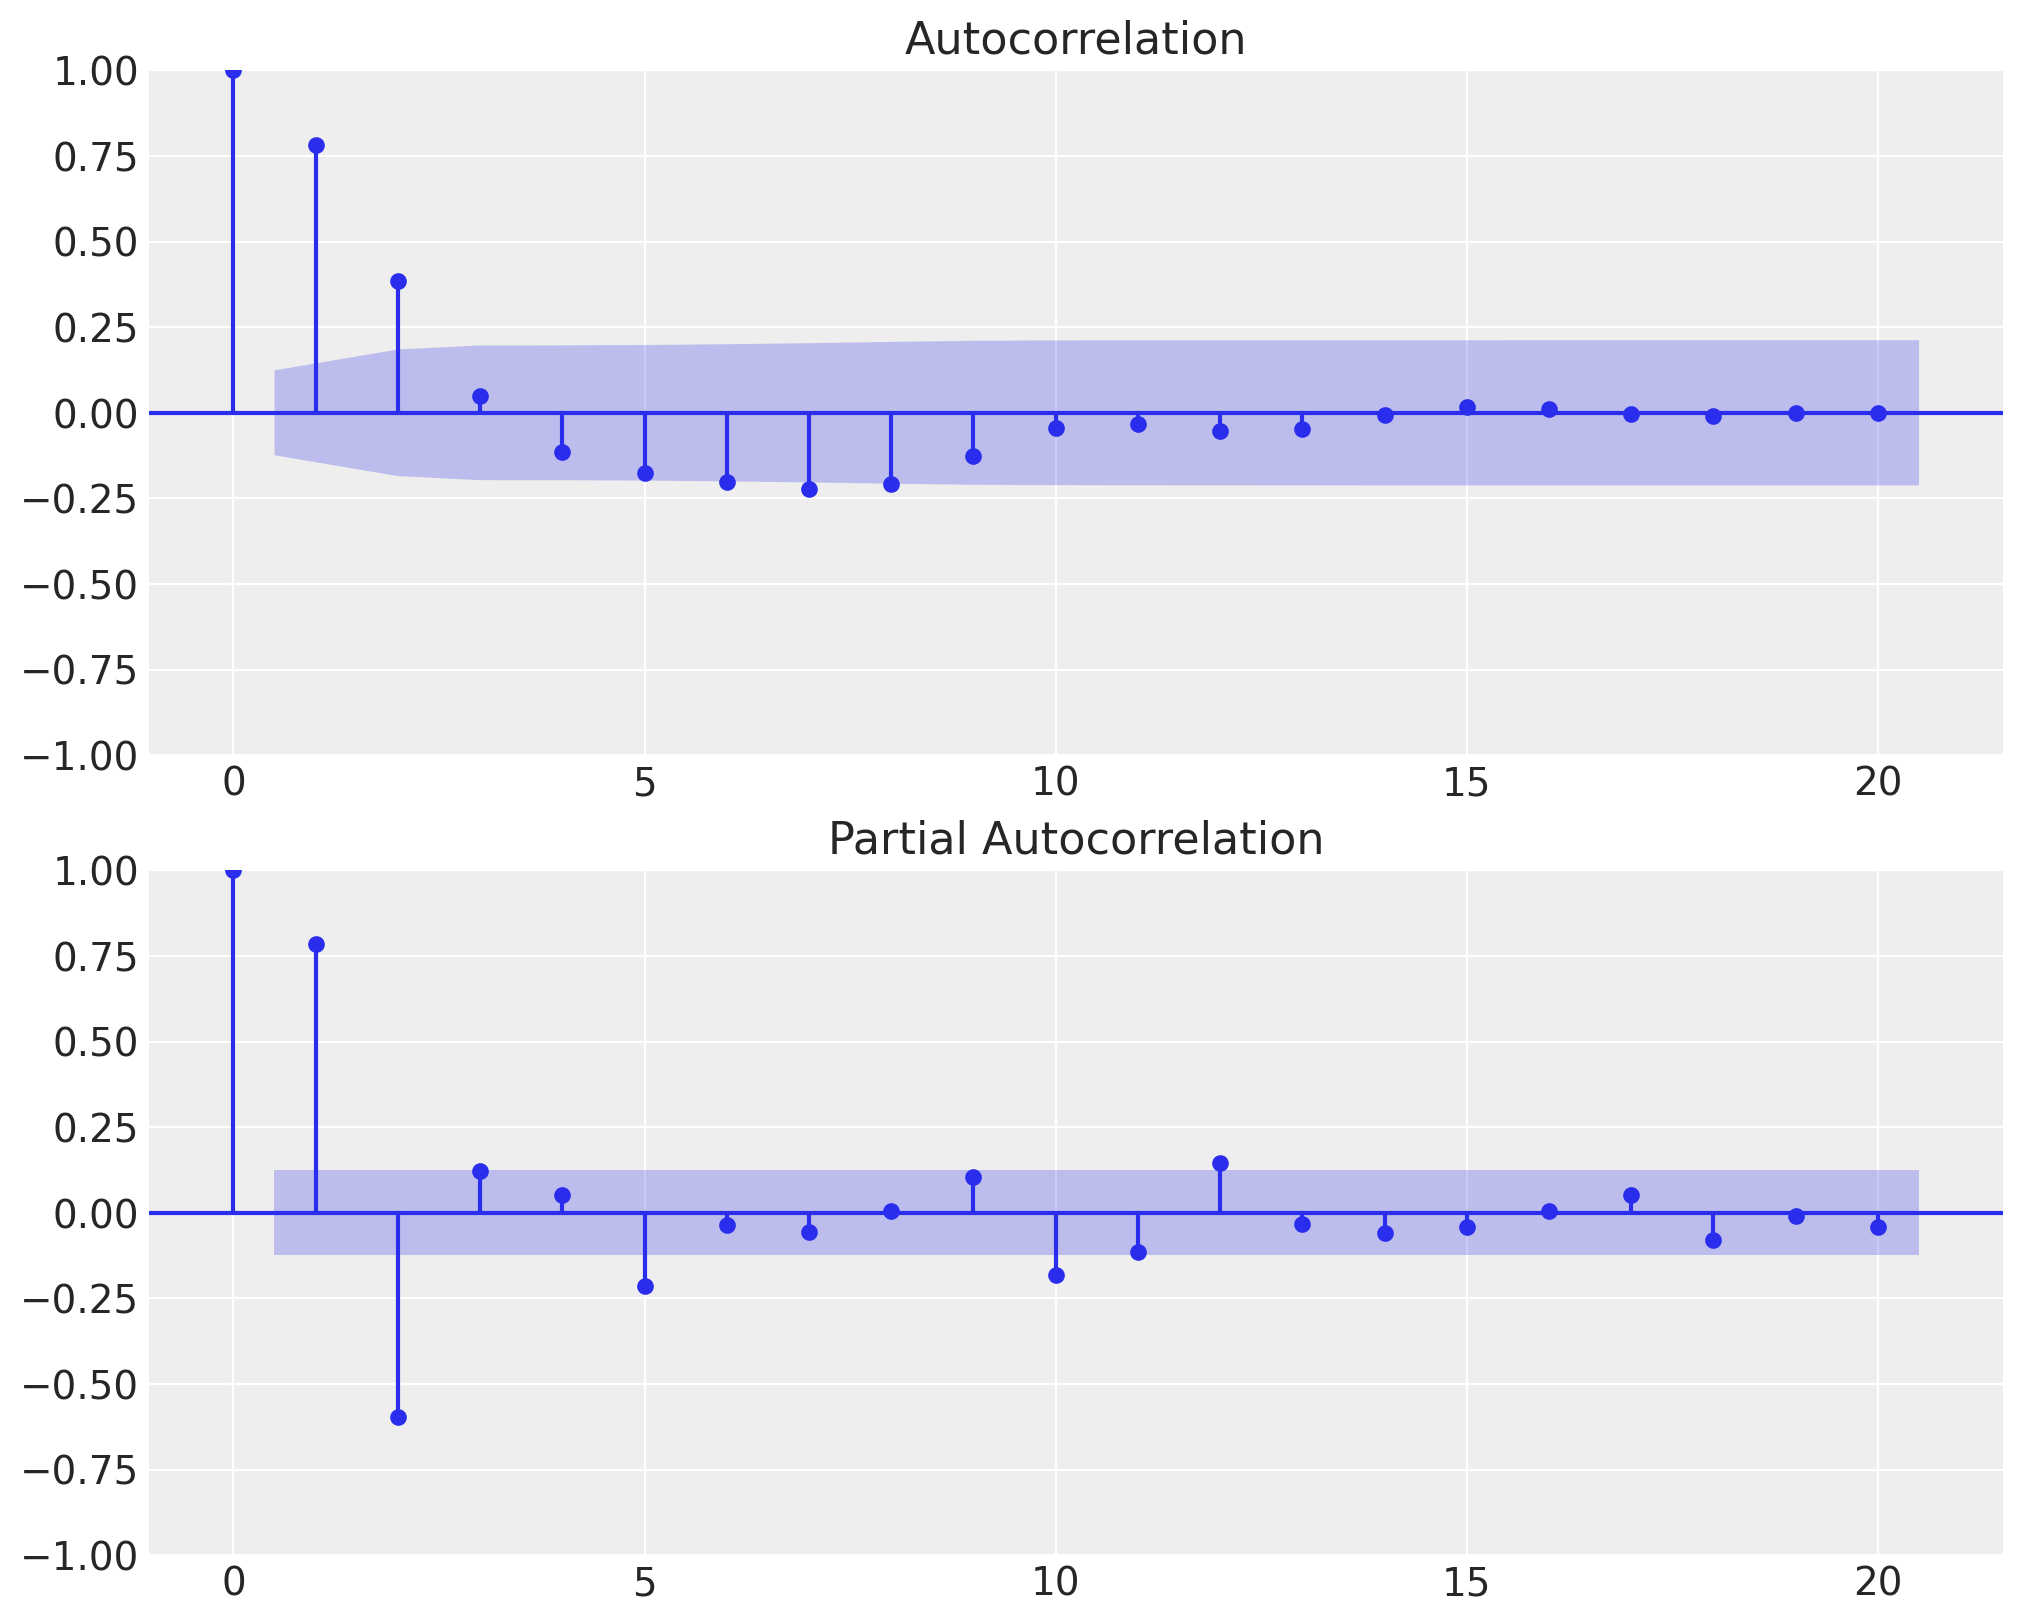

In [6]:
# plot acf and pacf 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8))
plot_acf(y, ax=ax1, lags=20)
plot_pacf(y, ax=ax2, lags=20)
plt.show()

In [7]:
# fit model
mod = sm.tsa.ARIMA(y, order=(2,0,2), trend='n')
res = mod.fit()

print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:                 ARIMA(2, 0, 2)   Log Likelihood                -346.801
Date:                Sat, 22 Apr 2023   AIC                            703.603
Time:                        22:13:06   BIC                            721.210
Sample:                             0   HQIC                           710.689
                                - 250                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5444      0.139      3.911      0.000       0.272       0.817
ar.L2         -0.1320      0.116     -1.139      0.255      -0.359       0.095
ma.L1          0.7891      0.129      6.095      0.0

In [8]:
%load_ext autoreload
%autoreload 2

from arma_inference import run_MCMC_ARMApq

In [9]:

model = {'order': [2, 2], 'tab': {'params': [1,0,0,0], 'bse': [1,1,1,1]}}
trace = run_MCMC_ARMApq(y, 2000, model)

ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: constant_folding
ERROR (pytensor.graph.rewriting.basic): node: Elemwise{add,no_inplace}(TensorConstant{(247,) of 0.0}, TensorConstant{(247,) of 0.0}, TensorConstant{(246,) of 0.0}, TensorConstant{(246,) of 0.0})
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/Users/wang/Library/CloudStorage/GoogleDrive-thetheoryofeverythingcn@gmail.com/My Drive/23 Spring/TimeSeries/Project/Bayesian-inference/.venv/lib/python3.9/site-packages/pytensor/graph/rewriting/basic.py", line 1918, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/Users/wang/Library/CloudStorage/GoogleDrive-thetheoryofeverythingcn@gmail.com/My Drive/23 Spring/TimeSeries/Project/Bayesian-inference/.venv/lib/python3.9/site-packages/pytensor/graph/rewriting/basic.py", line 1078, in transform
    return self.fn(fgraph, node)
  File "/Users/wang/Library/C

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 16 seconds.


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
phi[0]    1.030  1.012  -0.808    2.892      0.025    0.017    1684.0   
phi[1]    0.029  1.022  -1.872    1.950      0.024    0.018    1812.0   
theta[0] -0.037  1.010  -1.975    1.816      0.024    0.017    1802.0   
theta[1] -0.009  1.031  -1.918    1.920      0.026    0.018    1605.0   
sigma     1.957  0.087   1.796    2.122      0.001    0.001    3420.0   

          ess_tail  r_hat  
phi[0]      2162.0    1.0  
phi[1]      1871.0    1.0  
theta[0]    1845.0    1.0  
theta[1]    1998.0    1.0  
sigma       5342.0    1.0  


array([[<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>],
       [<Axes: title={'center': 'theta'}>,
        <Axes: title={'center': 'theta'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

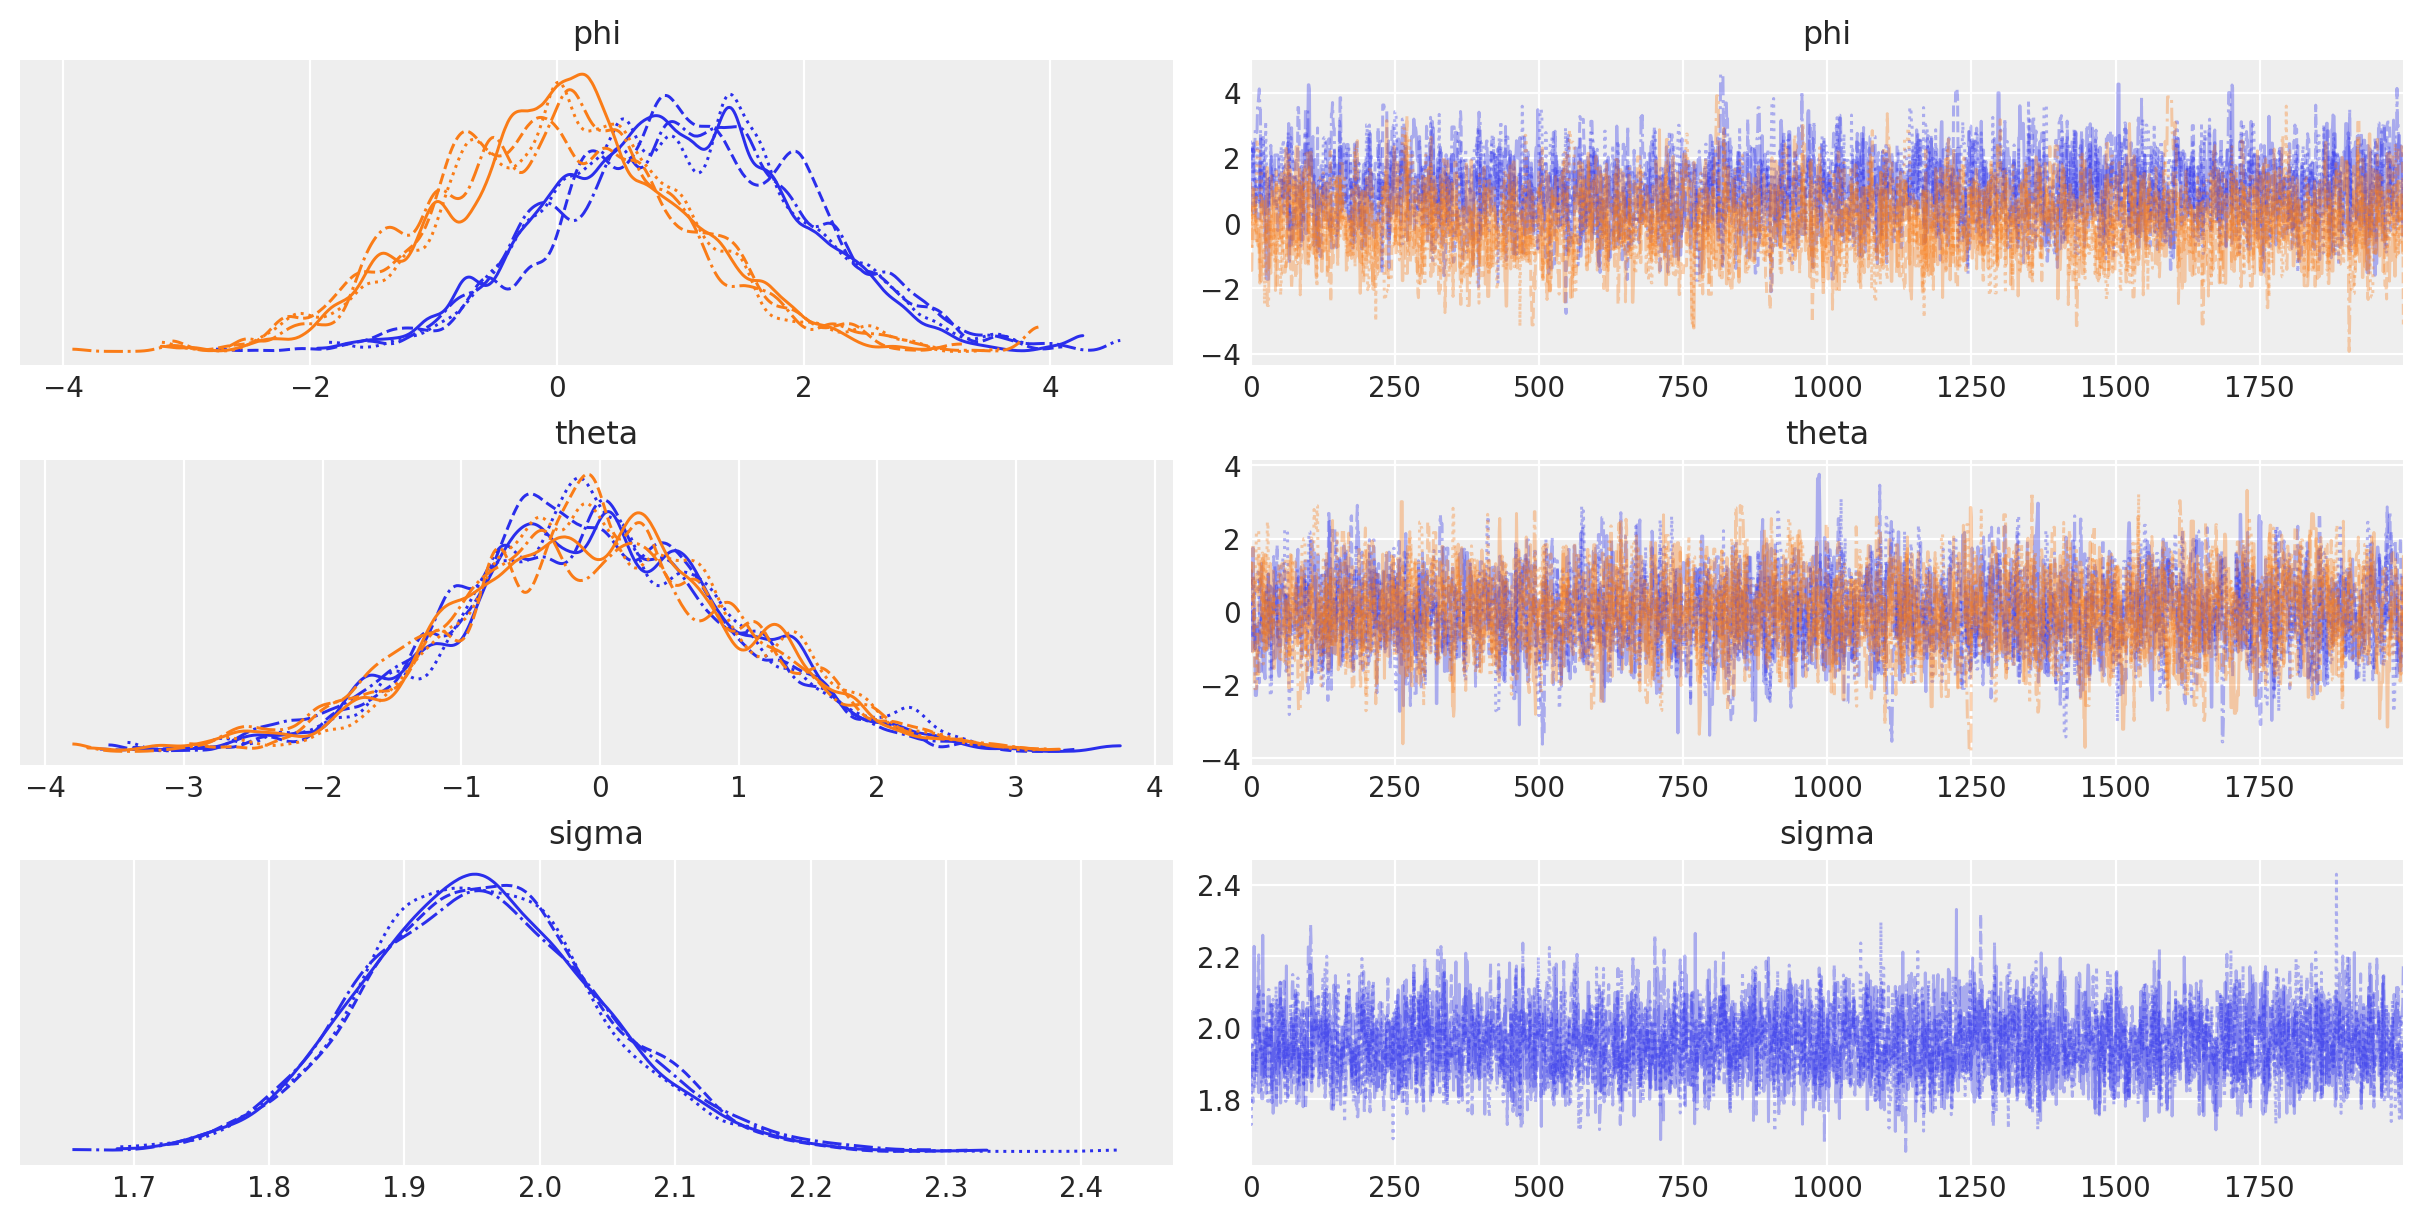

In [10]:
import arviz as az
az.style.use('arviz-darkgrid')
az.plot_trace(trace)

In [11]:
mod.loglike(res.params)

-346.8013977680366

In [12]:
import pytensor.tensor as tt

def logp(value: TensorVariable, params: TensorVariable):
    # extract parameters from tensors
    mod = sm.tsa.ARIMA(value.data, order=(2,0,2), trend='n')
    mod.fit()

    return tt.as_tensor(mod.loglikes(params.data))

NameError: name 'TensorVariable' is not defined

In [ ]:
with pm.Model() as bayesian_mod:
    phi_1 = pm.Normal('phi_1', mu=0, sigma=1)
    phi_2 = pm.Normal('phi_2', mu=0, sigma=1)
    theta_1 = pm.Normal('theta_1', mu=0, sigma=1)
    theta_2 = pm.Normal('theta_2', mu=0, sigma=1)
    sigma2 = pm.InverseGamma("sigma2", 2, 4)

    params = [phi_1, phi_2, theta_1, theta_2, sigma2]

    pm.CustomDist('likelihood', *params, logp, observed=y)

    trace = pm.sample(2000, tune=1000, cores=4)
    